In [84]:
import os
import subprocess

# Paths
alphapose_dir = "C:/Users/BRINTA/Downloads/He_2/AlphaPose"
video_dir = "C:/Users/BRINTA/Downloads/He_2/videos"
output_dir = "alphapose_output"

# AlphaPose model config and weights
cfg_file = os.path.join(alphapose_dir, "configs", "coco", "resnet", "256x192_res50_lr1e-3_1x.yaml")
checkpoint_file = os.path.join(alphapose_dir, "pretrained_models", "pose_resnet_50_256x192.pth")

# Ensure output directory exists
os.makedirs(output_dir, exist_ok=True)

# List all video files in the input directory
videos = [f for f in os.listdir(video_dir) if f.lower().endswith((".mp4", ".mov"))]

for video_file in videos:
    video_path = os.path.join(video_dir, video_file)
    video_name = os.path.splitext(video_file)[0]
    out_path = os.path.join(output_dir, video_name)

    os.makedirs(out_path, exist_ok=True)

    print(f"\n Running AlphaPose on: {video_file}")

    command = [
        "python",
        os.path.join(alphapose_dir, "scripts", "demo_inference.py"),
        "--cfg", cfg_file,
        "--checkpoint", checkpoint_file,
        "--video", video_path,
        "--outdir", out_path,
        "--save_video",
        "--vis_fast"
    ]

    # Run AlphaPose on this video
    subprocess.run(command)

print("\n Finished processing all videos.")



 Running AlphaPose on: v1.mp4

 Running AlphaPose on: v10.mp4

 Running AlphaPose on: v11.mp4

 Running AlphaPose on: v13.mp4

 Running AlphaPose on: v14.mp4

 Running AlphaPose on: v15.mp4

 Running AlphaPose on: v16.mp4

 Running AlphaPose on: v17.mp4

 Running AlphaPose on: v18.mp4

 Running AlphaPose on: v19.mp4

 Running AlphaPose on: v2.mp4

 Running AlphaPose on: v20.mp4

 Running AlphaPose on: v21.mp4

 Running AlphaPose on: v22.MOV

 Running AlphaPose on: v23.mp4

 Running AlphaPose on: v24.mp4

 Running AlphaPose on: v25.mp4

 Running AlphaPose on: v26.mp4

 Running AlphaPose on: v27.mp4

 Running AlphaPose on: v28.mp4

 Running AlphaPose on: v29.mp4

 Running AlphaPose on: v3.mp4

 Running AlphaPose on: v30.mp4

 Running AlphaPose on: v31.mp4

 Running AlphaPose on: v32.mp4

 Running AlphaPose on: v33.mp4

 Running AlphaPose on: v34.mp4

 Running AlphaPose on: v35.mp4

 Running AlphaPose on: v36.mp4

 Running AlphaPose on: v37.mp4

 Running AlphaPose on: v4.mp4

 Running Al

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import mediapipe as mp
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from keras_tuner import HyperModel, RandomSearch
import matplotlib.pyplot as plt

In [ ]:
# --- Constants & Enums ---
mp_pose = mp.solutions.pose
POSE_LANDMARKS = mp_pose.PoseLandmark

In [ ]:
# --- Data Loading & Preprocessing ---
def extract_landmarks_from_video(video_path, sampling_rate=5, confidence_threshold=0.7):
    pose = mp_pose.Pose(static_image_mode=False, min_detection_confidence=0.7, min_tracking_confidence=0.5)
    cap = cv2.VideoCapture(video_path)
    all_features = []
    frame_idx = 0

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        if frame_idx % sampling_rate == 0:
            features = extract_features_from_frame(frame, pose, confidence_threshold)
            if features is not None:
                all_features.append(features)

        frame_idx += 1

    cap.release()
    pose.close()
    return np.array(all_features) if all_features else None

def extract_features_from_frame(frame, pose, confidence_threshold):
    results = pose.process(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    if results.pose_landmarks:
        landmarks = [(lm.x, lm.y, lm.z, lm.visibility) for lm in results.pose_landmarks.landmark]
        landmarks = np.array([[(x if v > confidence_threshold else 0, 
                               y if v > confidence_threshold else 0,
                               z if v > confidence_threshold else 0) 
                              for x, y, z, v in [landmarks[i]]]
                             for i in range(len(landmarks))]).reshape(-1)

        if np.all(landmarks == 0):
            return None

        norm_landmarks = normalize_landmarks(landmarks)
        additional = calculate_additional_features(norm_landmarks)
        return np.concatenate((norm_landmarks, additional))
    return None

def normalize_landmarks(landmarks):
    left_hip = landmarks[POSE_LANDMARKS.LEFT_HIP.value*3:POSE_LANDMARKS.LEFT_HIP.value*3+3]
    left_shoulder = landmarks[POSE_LANDMARKS.LEFT_SHOULDER.value*3:POSE_LANDMARKS.LEFT_SHOULDER.value*3+3]
    torso_len = np.linalg.norm(left_hip - left_shoulder)
    return landmarks / (torso_len + 1e-6)

def calculate_additional_features(landmarks):
    def get(p): return landmarks[p*3:p*3+3]
    distances = [
        np.linalg.norm(get(POSE_LANDMARKS.LEFT_SHOULDER) - get(POSE_LANDMARKS.RIGHT_SHOULDER)),
        np.linalg.norm(get(POSE_LANDMARKS.LEFT_HIP) - get(POSE_LANDMARKS.RIGHT_HIP)),
        np.linalg.norm(get(POSE_LANDMARKS.NOSE) - get(POSE_LANDMARKS.LEFT_ANKLE)),
        np.linalg.norm(get(POSE_LANDMARKS.NOSE) - get(POSE_LANDMARKS.RIGHT_ANKLE))
    ]
    # Left knee angle
    hip = get(POSE_LANDMARKS.LEFT_HIP)
    knee = get(POSE_LANDMARKS.LEFT_KNEE)
    ankle = get(POSE_LANDMARKS.LEFT_ANKLE)
    v1, v2 = hip - knee, ankle - knee
    cos_theta = np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2) + 1e-6)
    angle = np.arccos(np.clip(cos_theta, -1.0, 1.0))
    return np.array(distances + [angle])

In [98]:
# --- Data Preparation ---
def load_dataset(data, image_folder):
    features, labels = [], []
    for _, row in data.iterrows():
        image_name = f"{os.path.splitext(row['video_name'])[0]}_frame{row['frame_index']}.jpg"
        image_path = os.path.join(image_folder, image_name)
        frame = cv2.imread(image_path)
        if frame is not None:
            pose = mp_pose.Pose(static_image_mode=True, min_detection_confidence=0.7)
            feature = extract_features_from_frame(frame, pose, 0.7)
            pose.close()
            if feature is not None:
                features.append(feature)
                labels.append(row['height'])
    return np.array(features), np.array(labels)

In [100]:
# --- Model ---
class HeightEstimationHyperModel(HyperModel):
    def build(self, hp):
        model = tf.keras.Sequential()
        model.add(tf.keras.layers.Input(shape=(X.shape[1],)))
        for i in range(hp.Int("num_layers", 1, 3)):
            units = hp.Int(f"units_{i}", 64, 256, step=64)
            model.add(tf.keras.layers.Dense(units))
            model.add(tf.keras.layers.LeakyReLU())
            model.add(tf.keras.layers.BatchNormalization())
            model.add(tf.keras.layers.Dropout(0.3))
        model.add(tf.keras.layers.Dense(1))
        model.compile(
            optimizer=tf.keras.optimizers.Adam(hp.Choice("lr", [1e-3, 1e-4, 1e-5])),
            loss="mse",
            metrics=["mae"]
        )
        return model

In [114]:
# --- Training ---
def train_model(X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
    tuner = RandomSearch(
        HeightEstimationHyperModel(),
        objective="val_mae",
        max_trials=10,
        executions_per_trial=1,
        directory="tuning",
        project_name="height_model"
    )
    tuner.search(X_train, y_train, epochs=10, validation_data=(X_val, y_val))
    best_model = tuner.get_best_models(1)[0]
    history = best_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=30)
    return best_model, history, X_val, y_val

In [124]:
# --- Evaluation ---
def evaluate(model, X_val, y_val):
    preds = model.predict(X_val).flatten()
    print("MAE:", mean_absolute_error(y_val, preds))
    print("RMSE:", mean_squared_error(y_val, preds, squared=False))
    print("R2:", r2_score(y_val, preds))
    return preds

   


In [142]:
preds = evaluate(model, X_val, y_val)

# Now show the first few predictions alongside actuals
for true, pred in zip(y_val[:5], preds[:5]):
    print(f"True: {true:.1f} cm | Predicted: {pred:.1f} cm")

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
MAE: 0.1065099117536043
RMSE: 0.13726132572629274
R2: 0.30981845907674055
True: 2.0 cm | Predicted: 1.8 cm
True: 1.7 cm | Predicted: 1.8 cm
True: 1.8 cm | Predicted: 1.8 cm
True: 1.9 cm | Predicted: 1.9 cm
True: 1.8 cm | Predicted: 1.8 cm


C:\Users\BRINTA\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
MAE: 0.1065099117536043
RMSE: 0.13726132572629274
R2: 0.30981845907674055


C:\Users\BRINTA\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

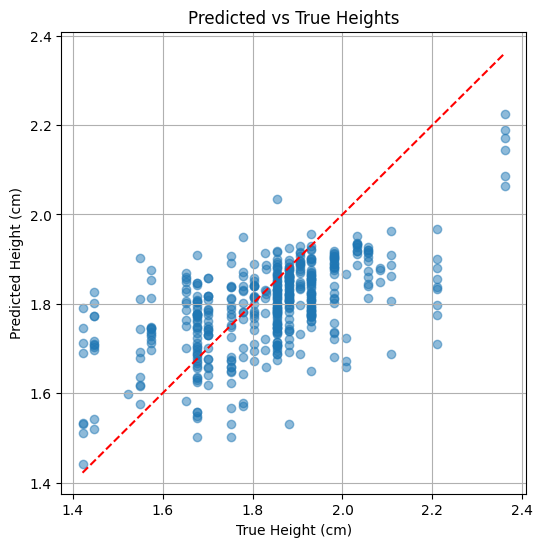

In [138]:
preds = evaluate(model, X_val, y_val)

# Plot predictions
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(6, 6))
plt.scatter(y_val, preds, alpha=0.5)
plt.plot([min(y_val), max(y_val)], [min(y_val), max(y_val)], 'r--')
plt.xlabel("True Height (cm)")
plt.ylabel("Predicted Height (cm)")
plt.title("Predicted vs True Heights")
plt.grid(True)
plt.show()


In [140]:
# --- Prediction ---
def predict_from_video(video_path, model, scaler):
    features = extract_landmarks_from_video(video_path)
    if features is None or len(features) == 0:
        return None
    features_scaled = scaler.transform(features)
    preds = model.predict(features_scaled)
    mean = np.mean(preds)
    std = np.std(preds)
    filtered = preds[(preds > mean - std) & (preds < mean + std)]
    return np.mean(filtered) if len(filtered) > 0 else mean

In [157]:
# --- Usage Example ---
if __name__ == "__main__":
    csv_file_path = r"C:/Users/BRINTA/Downloads/He_2/H_data/athlete_heights.csv"
    data_folder = r"C:/Users/BRINTA/Downloads/He_2/H_data"

    df = pd.read_csv(csv_file_path)
    X, y = load_dataset(df, data_folder)

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    model, history, X_val, y_val = train_model(X_scaled, y)
    evaluate(model, X_val, y_val)

Reloading Tuner from tuning\height_model\tuner0.json
Epoch 1/30


C:\Users\BRINTA\anaconda3\Lib\site-packages\keras\src\saving\saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 0.2871 - mae: 0.4000 - val_loss: 0.0868 - val_mae: 0.2377
Epoch 2/30
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.2285 - mae: 0.3468 - val_loss: 0.0567 - val_mae: 0.1741
Epoch 3/30
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.1789 - mae: 0.3226 - val_loss: 0.0431 - val_mae: 0.1516
Epoch 4/30
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.1473 - mae: 0.2823 - val_loss: 0.0587 - val_mae: 0.1898
Epoch 5/30
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.1176 - mae: 0.2631 - val_loss: 0.0404 - val_mae: 0.1598
Epoch 6/30
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.1187 - mae: 0.2544 - val_loss: 0.0606 - val_mae: 0.1938
Epoch 7/30
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.1094 - mae: 0.2489 - val_loss: 0.0347 - val_mae: 0.1374
Epoch 8/30
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0824 - mae: 0.2183 - val_loss: 0.0371 - val_mae: 0.1522
Epoch 9/30
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0839 - mae: 0.

C:\Users\BRINTA\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [155]:
## Test Run 


video_path = r'C:/Users/BRINTA/Downloads/He_2/videos/v86.mp4'
predicted_height = predict_from_video(video_path, model, scaler)
print(f"Predicted Height: {predicted_height:.2f} m")


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Predicted Height: 1.80 cm


In [158]:
#Test run 2 

video_path = r'C:/Users/BRINTA/Downloads/He_2/videos/v84.mp4'
predicted_height = predict_from_video(video_path, model, scaler)
print(f"Predicted Height: {predicted_height:.2f} m")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
Predicted Height: 2.06 cm


In [159]:
#Test run 3

video_path = r'C:/Users/BRINTA/Downloads/He_2/videos/v1.mp4'
predicted_height = predict_from_video(video_path, model, scaler)
print(f"Predicted Height: {predicted_height:.2f} m")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Predicted Height: 1.79 cm
